In [25]:
from __future__ import print_function
import cntk
import numpy as np
import scipy.sparse
import cntk.tests.test_utils
cntk.tests.test_utils.set_device_from_pytest_env() # (only needed for our build system)
cntk.cntk_py.set_fixed_random_seed(1) # fix the random seed so that examples produce the same results each time
from IPython.display import Image
import matplotlib.pyplot
%matplotlib inline
matplotlib.pyplot.rcParams['figure.figsize'] = (40,40)

# CNTK Quick Start Guide

Welcome to CNTK and the wonders of deep learning! This tutorial will give a brief overview of CNTK. It is meant for users that are new to CNTK but have some experience with deep neural networks.
The focus will be on how the basic steps of deep learning are done in CNTK.

To train a deep model, you will need to:

 * Define your **model structure**.
 * Prepare your **data**.
 * **Train** it.
 * **Evaluate** its accuracy.
 * **Deploy** it.

This tutorial is structured along these five steps.

To run this tutorial, you will need CNTK 2.0 and ideally a CUDA-capable GPU (deep learning is no fun without GPUs).

## Defining Your Model Structure

So let us dive right in. Below we will introduce CNTK's programming model--*networks are function objects* and CNTK's data model. We will put that into action for logistic regression and MNIST digit recognition,
using CNTK's Functional API.
Lastly, we will replicate one example using CNTK's lower-level, TensorFlow/Theano-like graph API.

#### Programming Model: Networks are Function Objects

In CNTK, a neural network is a function object.
On one hand, a neural network in CNTK is just a function that you can call
to apply it to data.
On the other hand, a neural network contains learnable parameters
that can be accessed like object members.
Complicated function objects can be composed as hierarchies of simpler ones, which,
for example, represent layers.
The function-object approach is similar to Keras, Chainer, Dynet, Pytorch,
and the recent Sonnet.

The following illustrates the function-object approach with pseudo-code, using the example
of a fully-connected layer (called `Dense` in CNTK)::


In [26]:
# numpy *pseudo-code* for CNTK Dense layer (vastly simplified, e,g. no back-prop)
def Dense(out_dim, activation):
    # create the learnable parameters
    b = np.zeros(out_dim)
    W = np.ndarray((0,out_dim)) # input dimension is unknown
    # define the function itself
    def dense(x):
        if len(W) == 0:         # first call: reshape and initialize W
            W.resize((x.shape[-1], W.shape[-1]), refcheck=False)
            W[:] = np.random.randn(*W.shape) * 0.05
        return activation(x @ W + b)
    # return it as a function object: can be called & holds the parameters as members
    dense.W = W
    dense.b = b
    return dense

d = Dense(5, np.tanh)    # create the function object
y = d(np.array([1, 2]))  # apply it like a function
W = d.W                  # access member like an object
print('W =', d.W)
print('y =', y)

W = [[ 0.06484214  0.0668272  -0.06177861  0.05454117  0.00123526]
 [-0.08024099  0.04517105  0.06488221 -0.09801994 -0.02767334]]
y = [-0.0953493   0.15588782  0.06788126 -0.14056186 -0.05405867]


Note that the real CNTK function objects are not actual Python lambdas.
Rather, they are static graphs in C++,
wrapped in the Python class `Function` that exposes `__call__()` and `__getattr__()` methods.
However, CNTK allows to define networks as Python expressions and functions,
as long as they can be converted into static graphs of type `Function`.

The function object is CNTK's single abstraction used to represent different levels of neural networks, which
are only distinguished by convention:

 * **basic operations** without learnable parameters (e.g. `times()`, `__add__()`, `sigmoid()`...)
 * **layers** (`Dense()`, `Embedding()`, `Convolution()`...). Layers map one input to one output.
 * **recurrent step functions** (`LSTM()`, `GRU()`, `RNNStep()`). Step functions map a previous state and a new input to a new state.
 * **loss and metric** functions (`cross_entropy_with_softmax()`, `binary_cross_entropy()`, `squared_error()`, `classification_error()`...).
   In CNTK, losses and metric are not special, just functions.
 * **models**. Models are defined by the user and map features to predictions or scores, and is what gets deployed in the end.
 * **criterion function**. The criterion function maps (features, labels) to (loss, metric).
   The Trainer optimizes the loss by SGD, and logs the metric, which may be non-differentiable.

Higher-order layers compose objects into more complex ones, including:

 * **stacking** (`Sequential()`, `For()`)
 * **recurrence** (`Recurrence()`, `Fold()`, `Unfold()`...)

Users can use arbitrary Python expressions as CNTK function objects with `Function()`.
This is similar to Keras' `Lambda()`.
Expressions can be written as multi-line functions through decorator syntax (`@Function`).

Lastly, function objects enable parameter sharing. If you call the same
function object at multiple places, all invocations will naturally share the same learnable parameters.

In summary, the function object is CNTK's single abstraction for conveniently defining
simple and complex models, parameter sharing, and training objectives.

(Note that under the hood, CNTK uses a static graph,
and it is possible to define CNTK networks as graphs like TensorFlow and Theano, as discussed
further below.)

### CNTK's Data model: Sequences of Tensors

CNTK can operate on two types of data:

 * **tensors** (that is, N-dimensional arrays), dense or sparse
 * **sequences** of tensors

The distinction is that the shape of a tensor is static during operation,
while the length of a sequence depends on data.
Tensors have *static axes*, while a sequence has a *dynamic axis*.

In CNTK, categorical data is represented as sparse one-hot tensors, not as integer vectors.
This allows to write embeddings and loss functions in a unified fashion as matrix products.

CNTK adopts Python's type-annotation syntax to declare CNTK types.
For example,

 * `Tensor[(13,42)]` denotes a tensor with 13 rows and 42 columns, and
 * `Sequence[SparseTensor[300000]]` a sequence of sparse vectors, which for example could represent a word out of a 300k dictionary

Note that unlike Python type hints, this works with Python 2.7. There are two more data types: 'batch of tensors' and 'batch of sequences of tensors'.
These are used internally for minibatching, but we generally try to hide batching from the user:
We want users to think in tensors and sequences, and leave mini-batching to CNTK.
To this end, unlike other toolkits, CNTK transparently batches *sequences with different lengths*
into the same minibatch, and handles all the necessary padding and packing.
Workarounds like 'bucketing' are not needed.

### Your First CNTK Network: Simple Logistic Regression

Let us put all of this in action for a very simple example of logistic regression.
For this example, we create a synthetic data set of 2-dimensional normal-distributed 
data points, which should be classified into belonging to one of two classes.
Note that CNTK expects the labels as one-hot encoded.


In [27]:
input_dim_lr = 2    # classify 2-dimensional data
num_classes_lr = 2  # into one of two classes

# This example uses synthetic data from normal distributions, which we generate in the following.
#  X_lr[corpus_size,input_dim] - input data
#  Y_lr[corpus_size]           - labels (0 or 1), in one-hot representation
np.random.seed(0)
def generate_synthetic_data(N):
    Y = np.random.randint(size=N, low=0, high=num_classes_lr)  # labels
    X = (np.random.randn(N, input_dim_lr)+3) * (Y[:,None]+1)   # data
    # Our model expects float32 features, and cross-entropy expects one-hot encoded labels.
    Y = scipy.sparse.csr_matrix((np.ones(N,np.float32), (range(N), Y)), shape=(N, num_classes_lr))
    X = X.astype(np.float32)
    return X, Y
X_train_lr, Y_train_lr = generate_synthetic_data(20000)
X_test_lr,  Y_test_lr  = generate_synthetic_data(1024)
X_train_lr, Y_train_lr.todense() # let's have a peek
print(X_train_lr[:4])
print(Y_train_lr[:4].todense())

[[ 2.2741797   3.56347561]
 [ 5.12873602  5.79089499]
 [ 1.3574543   5.5718112 ]
 [ 3.54340553  2.46254587]]
[[ 1.  0.]
 [ 0.  1.]
 [ 0.  1.]
 [ 1.  0.]]


We now define the model function. The model function maps input data to predictions.
It is the final product of the training process.
In this example, we use the simplest of all models: logistic regression.

In [28]:
model_lr = cntk.layers.Dense(num_classes_lr, activation=None)

Next, we define the criterion function. The criterion function is
the harness via which the trainer uses to optimize the model:
It maps (input vectors, labels) to (loss, metric).
The loss is used for the SGD updates. We choose cross entropy.
Specifically, `cross_entropy_with_softmax()` first applies
the `softmax()` function to the network's output, as
cross entropy expects probabilities.
We do not include `softmax()` in the model function itself, because
it is not necessary for using the model.
As the metric, we count classification errors (this metric is not differentiable).

We define criterion function as Python code and convert it to a `Function` object.
A single expression can be written as `Function(lambda x, y: `*expression of x and y*`)`,
similar to Keras' `Lambda()`.
To avoid evaluating the model twice, we use a Python function definition
with decorator syntax. Lastly, this is a good time to tell CNTK about the
data types of our inputs, which is done via the decorator `@Function.with_signature(`*argument types*`)`:

In [29]:
@cntk.Function.with_signature(cntk.layers.Tensor[input_dim_lr], cntk.layers.SparseTensor[num_classes_lr])
def criterion_lr(data, label_one_hot):
    z = model_lr(data)  # apply model. Computes a non-normalized log probability for every output class.
    loss   = cntk.cross_entropy_with_softmax(z, label_one_hot) # this applies softmax to z under the hood
    metric = cntk.classification_error(z, label_one_hot)
    return loss, metric
print(criterion_lr)
print(model_lr.W.value) # W now has known shape and thus gets initialized

Composite(data: Tensor[2], label_one_hot: SparseTensor[2]) -> Tuple[Tensor[1], Tensor[1]]
[[-0.89681542 -0.89061725]
 [-0.11949861 -1.17324626]]


The decorator will 'compile' the function into a static graph
by calling `criterion()` passing it input variables of the given data types as arguments.
Thus, `criterion` is not a Python function but a static graph in a CNTK `Function` object.

We are now ready to train our model.

In [30]:
learner = cntk.sgd(model_lr.parameters, cntk.learning_rate_schedule(0.1, cntk.UnitType.minibatch))
progress_writer = cntk.logging.ProgressPrinter(50)

criterion_lr.train((X_train_lr, Y_train_lr), parameter_learners=[learner], callbacks=[progress_writer])

print(model_lr.W.value) # peek at updated W

Learning rate per minibatch: 0.1
 Minibatch[   1-  50]: loss = 0.663274 * 1600, metric = 37.31% * 1600;
 Minibatch[  51- 100]: loss = 0.481867 * 1600, metric = 20.56% * 1600;
 Minibatch[ 101- 150]: loss = 0.402196 * 1600, metric = 12.94% * 1600;
 Minibatch[ 151- 200]: loss = 0.386619 * 1600, metric = 13.75% * 1600;
 Minibatch[ 201- 250]: loss = 0.328646 * 1600, metric = 9.19% * 1600;
 Minibatch[ 251- 300]: loss = 0.301831 * 1600, metric = 9.50% * 1600;
 Minibatch[ 301- 350]: loss = 0.299345 * 1600, metric = 9.44% * 1600;
 Minibatch[ 351- 400]: loss = 0.279577 * 1600, metric = 8.94% * 1600;
 Minibatch[ 401- 450]: loss = 0.281061 * 1600, metric = 8.25% * 1600;
 Minibatch[ 451- 500]: loss = 0.261366 * 1600, metric = 7.81% * 1600;
 Minibatch[ 501- 550]: loss = 0.244967 * 1600, metric = 7.12% * 1600;
 Minibatch[ 551- 600]: loss = 0.243953 * 1600, metric = 8.31% * 1600;
Finished Epoch[1]: loss = 0.344399 * 20000, metric = 12.58% * 20000 7.356s (2718.9 samples/s);
[[-1.25055134 -0.53687745]
 

The `learner` is the object that actually performs the model update. Alternative learners include `momentum_sgd()` and `adam()`. The `progress_writer` is a stock logging callback that prints the output you see above, and can be replaced by your own
or the stock `TensorBoardProgressWriter`to visualize training progress using TensorBoard.

The `train()` function is feeding our data `(X_train_lr, Y_train_lr)` minibatch by minibatch to the model and updates it, where the data is a tuple in the same order as the arguments of `criterion_mn()`.

Let us test how we are doing on our test set (this will also run minibatch by minibatch).

In [31]:
test_metric = criterion_lr.test((X_test_lr, Y_test_lr), callbacks=[progress_writer]).metric

Finished Evaluation [1]: Minibatch[1-32]: metric = 8.11% * 1024;


And lastly, let us run a few samples through our model and see how it is doing.
Oops, `criterion` knew the input types, but `model_lr` does not,
so we tell it using `update_signature()`.

In [32]:
model_lr.update_signature(cntk.layers.Tensor[input_dim_lr])
print(model_lr)

Dense(x: Tensor[2]) -> Tensor[2]


Now we can call it like any Python function:

In [33]:
z = model_lr(X_test_lr[:25])
print("Label    :", [label.todense().argmax() for label in Y_test_lr[:25]])
print("Predicted:", [z[i,:].argmax() for i in range(len(z))])

Label    : [0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0]
Predicted: [0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0]


### Your Second CNTK Network: MNIST Digit Recognition

Let us do the same thing as above on an actual task--the MNIST benchmark, which is sort of the "hello world" of deep learning.
The MNIST task is to recognize scans of hand-written digits. We first download and prepare the data.

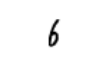

In [34]:
input_shape_mn = (28, 28)  # MNIST digits are 28 x 28
num_classes_mn = 10        # classify as one of 10 digits

# Fetch the MNIST data. Best done with scikit-learn.
try:
    from sklearn import datasets, utils
    mnist = datasets.fetch_mldata("MNIST original")
    X, Y = mnist.data / 255.0, mnist.target
    X_train_mn, X_test_mn = X[:60000].reshape((-1,28,28)), X[60000:].reshape((-1,28,28))
    Y_train_mn, Y_test_mn = Y[:60000].astype(int), Y[60000:].astype(int)
except: # workaround if scikit-learn is not present
    import requests, io, gzip
    X_train_mn, X_test_mn = (np.fromstring(gzip.GzipFile(fileobj=io.BytesIO(requests.get('http://yann.lecun.com/exdb/mnist/' + name + '-images-idx3-ubyte.gz').content)).read()[16:], dtype=np.uint8).reshape((-1,28,28)).astype(np.float32) / 255.0 for name in ('train', 't10k'))
    Y_train_mn, Y_test_mn = (np.fromstring(gzip.GzipFile(fileobj=io.BytesIO(requests.get('http://yann.lecun.com/exdb/mnist/' + name + '-labels-idx1-ubyte.gz').content)).read()[8:], dtype=np.uint8).astype(int) for name in ('train', 't10k'))

# Shuffle the training data.
np.random.seed(0) # always use the same reordering, for reproducability
idx = np.random.permutation(len(X_train_mn))
X_train_mn, Y_train_mn = X_train_mn[idx], Y_train_mn[idx]

# Further split off a cross-validation set
X_train_mn, X_cv_mn = X_train_mn[:54000], X_train_mn[54000:]
Y_train_mn, Y_cv_mn = Y_train_mn[:54000], Y_train_mn[54000:]

# Our model expects float32 features, and cross-entropy expects one-hot encoded labels.
Y_train_mn, Y_cv_mn, Y_test_mn = (scipy.sparse.csr_matrix((np.ones(len(Y),np.float32), (range(len(Y)), Y)), shape=(len(Y), 10)) for Y in (Y_train_mn, Y_cv_mn, Y_test_mn))
X_train_mn, X_cv_mn, X_test_mn = (X.astype(np.float32) for X in (X_train_mn, X_cv_mn, X_test_mn))

# have a peek
matplotlib.pyplot.rcParams['figure.figsize'] = (0.5,0.5)
matplotlib.pyplot.axis('off')
_ = matplotlib.pyplot.imshow(X_train_mn[13], cmap="gray_r")

Let's define the CNTK model function to map (28x28)-dimensional images to a 10-dimensional score vector.

In [35]:
with cntk.layers.default_options(activation=cntk.ops.relu, pad=False):
    model_mn = cntk.layers.Sequential([
        cntk.layers.Convolution2D((5,5), num_filters=32, reduction_rank=0, pad=True), # reduction_rank=0 for B&W images
        cntk.layers.MaxPooling((2,2), strides=(2,2)),
        cntk.layers.Convolution2D((3,3), num_filters=48),
        cntk.layers.MaxPooling((2,2), strides=(2,2)),
        cntk.layers.Convolution2D((3,3), num_filters=64),
        cntk.layers.Dense(96),
        cntk.layers.Dropout(dropout_rate=0.5),
        cntk.layers.Dense(num_classes_mn, activation=None) # no activation in final layer (softmax is done in criterion)
    ])

This model is a tad bit more complicated! It consists of several convolution-pooling layeres and two
fully-connected layers for classification which is typical for MNIST. This demonstrates several aspects of CNTK's Functional API.

First, we create each layer using a function from CNTK's layers library (`cntk.layers`).

Second, the higher-order layer `Sequential()` creates a new function that applies all those layers
one after another. This is known [forward function composition](https://en.wikipedia.org/wiki/Function_composition).
Note that unlike some other toolkits, you cannot `Add()` more layers afterwards to a sequential layer.
CNTK's `Function` objects are immutable, besides their learnable parameters (to edit a `Function` object, you can `clone()` it).
If you prefer that style, create your layers as a Python list and pass that to `Sequential()`.

Third, the context manager `default_options()` allows to specify defaults for various optional arguments to layers,
such as that the activation function is always `relu`, unless overriden.

Lastly, note that `relu` is passed as the actual function, not a string.
Any function can be an activation function.
It is also allowed to pass a Python lambda directly, for example relu could also be
realized manually by saying `activation=lambda x: cntk.ops.element_max(x, 0)`.

The criterion function is defined like in the previous example, to map maps (28x28)-dimensional features and according
labels to loss and metric.

In [36]:
@cntk.Function.with_signature(cntk.layers.Tensor[input_shape_mn], cntk.layers.SparseTensor[num_classes_mn])
def criterion_mn(data, label_one_hot):
    z = model_mn(data)
    loss   = cntk.cross_entropy_with_softmax(z, label_one_hot)
    metric = cntk.classification_error(z, label_one_hot)
    return loss, metric

For the training, let us throw momentum into the mix.

In [37]:
N = len(X_train_mn)
lr = cntk.learning_rate_schedule([0.001]*12 + [0.0005]*6 + [0.00025]*6 + [0.000125]*3 + [0.0000625]*3 + [0.00003125], cntk.learners.UnitType.sample, epoch_size=N)
momentums = cntk.learners.momentum_as_time_constant_schedule([0]*5 + [1024], epoch_size=N)
minibatch_sizes = cntk.minibatch_size_schedule([256]*6 + [512]*9 + [1024]*7 + [2048]*8 + [4096], epoch_size=N)

learner = cntk.learners.momentum_sgd(model_mn.parameters, lr, momentums)

This looks unusual in several aspects.
First, the learning rate is specified as a list (`[0.001]*12 + [0.0005]*6 +`...). Together with the `epoch_size` parameter, this tells CNTK to use 0.001 for 12 epochs, and then continue with 0.005 for another 6, etc.

Second, the learning rate has `cntk.learners.UnitType.sample` (vs. `cntk.UnitType.minibatch`). This tells CNTK to apply the learning rate not to the minibatch-*average*, but to each sample (or, the minibatch-*sum*). To get the same convergence, the learning rate must be divided by the minibatch size, hence the small value.

Third, momentum is specified as a time constant of 1024. This says that for a minibatch size of 64, after 1024/64=16 minibatches, each sample gradient still contributes with a weight of 1/e.

But why?? In our experience, the effect of learning rates and momentum on training convergence, when specified this way, tends to be independent of the minibatch size within a wide range. The minibatch size now just means how 'outdated' the model is before we update it.
The minibatch size is crucial for efficiency of GPUs and parallel training, and this way it can be tuned while keeping learning rate and momentum the same. We find that it is possible to crank up the minibatch size to much larger values during the training. The minibatch-size schedule yields 6-times speed-up (!) towards the end (on a Titan-X).

Having this out of the way, let us now train the model. On a Titan-X, this will run for about a minute.

In [38]:
progress_writer = cntk.logging.ProgressPrinter()
criterion_mn.train((X_train_mn, Y_train_mn), minibatch_size=minibatch_sizes,
                   max_epochs=40, parameter_learners=[learner], callbacks=[progress_writer])
test_metric = criterion_mn.test((X_test_mn, Y_test_mn), callbacks=[progress_writer]).metric

Learning rate per sample: 0.001
Momentum per sample: 0.0
Finished Epoch[1]: loss = 0.545271 * 54000, metric = 17.65% * 54000 8.561s (6307.7 samples/s);
Finished Epoch[2]: loss = 0.134691 * 54000, metric = 3.95% * 54000 8.210s (6577.3 samples/s);
Finished Epoch[3]: loss = 0.095339 * 54000, metric = 2.72% * 54000 8.934s (6044.3 samples/s);
Finished Epoch[4]: loss = 0.074736 * 54000, metric = 2.13% * 54000 9.816s (5501.2 samples/s);
Finished Epoch[5]: loss = 0.062433 * 54000, metric = 1.83% * 54000 8.356s (6462.4 samples/s);
Momentum per sample: 0.9990239141819757
Finished Epoch[6]: loss = 0.054977 * 54000, metric = 1.58% * 54000 8.846s (6104.5 samples/s);
Finished Epoch[7]: loss = 0.047248 * 54000, metric = 1.33% * 54000 4.783s (11290.0 samples/s);
Finished Epoch[8]: loss = 0.039817 * 54000, metric = 1.13% * 54000 5.593s (9654.9 samples/s);
Finished Epoch[9]: loss = 0.036338 * 54000, metric = 1.11% * 54000 4.781s (11294.7 samples/s);
Finished Epoch[10]: loss = 0.033888 * 54000, metric = 

### Graph API Example: MNIST Digit Recognition Again

CNTK also allows networks to be written in graph style like TensorFlow and Theano. The following defines the same model and criterion function as above, and you would get the same result if you had run the training above with the definition below (if you try that now, results will differ due to random initialization).

In [39]:
images = cntk.input_variable(input_shape_mn, name='images')
with cntk.layers.default_options(activation=cntk.ops.relu, pad=False):
    r = cntk.layers.Convolution2D((5,5), num_filters=32, reduction_rank=0, pad=True)(images)
    r = cntk.layers.MaxPooling((2,2), strides=(2,2))(r)
    r = cntk.layers.Convolution2D((3,3), num_filters=48)(r)
    r = cntk.layers.MaxPooling((2,2), strides=(2,2))(r)
    r = cntk.layers.Convolution2D((3,3), num_filters=64)(r)
    r = cntk.layers.Dense(96)(r)
    r = cntk.layers.Dropout(dropout_rate=0.5)(r)
    model_mn = cntk.layers.Dense(num_classes_mn, activation=None)(r)

label_one_hot = cntk.input_variable(num_classes_mn, is_sparse=True, name='labels')
loss   = cntk.cross_entropy_with_softmax(model_mn, label_one_hot)
metric = cntk.classification_error(model_mn, label_one_hot)
criterion_mn = cntk.combine([loss, metric])
print(criterion_mn)

Composite(images: Tensor[28,28], labels: SparseTensor[10]) -> Tuple[Tensor[1], Tensor[1]]


## Feeding Your Data

Once you have decided your model structure and defined it, you are facing the question on feeding
your training data to the CNTK training process.

The above examples simply feed the data as numpy/scipy arrays.
That is only one of three ways CNTK provides for feeding data to the trainer:

 1. As **numpy/scipy arrays**, for small data sets that can just be loaded into RAM.
 2. Through instances of **CNTK's MinibatchSource class**, for large data sets that do not fit into RAM.
 3. Through an **explicit minibatch-loop** when the above do not apply.

### 1. Feeding Data Via Numpy/Scipy Arrays

The `train()` and `test()` functions accept a tuple of numpy or scipy arrays for their `minibatch_source` arguments.
The tuple members must be in the same order as the arguments of the `criterion` function that `train()` or `test()` are called on.
For dense tensors, use numpy arrays, while sparse data should have the type `scipy.sparse.csr_matrix`.

Each of the arguments should be a Python list of numpy/scipy arrays, where each list entry represents a data item. For arguments declared as `Sequence[...]`, the first axis of the numpy/scipy array is the sequence length, while the remaining axes are the shape of each token of the sequence. Arguments that are not sequences consist of a single tensor. The shapes, data types (`np.float32/float64`) and sparseness must match the argument types as declared in the criterion function.

As an optimization, arguments that are not sequences can also be passed as a single large numpy/scipy array (instead of a list). This is what is done in the examples above.

Note that it is the responsibility of the user to randomize the data.

### 2. Feeding Data Using the `MinibatchSource` class for Reading Data

Production-scale training data sometimes does not fit into RAM. For example, a typical speech corpus may be several hundred GB large. For this case, CNTK provides the `MinibatchSource` class, which provides:

 * A **chunked randomization algorithm** that holds only part of the data in RAM at any given time.
 * **Distributed reading** where each worker reads a different subset.
 * A **transformation pipeline** for images and image augmentation.
 * **Composability** across multiple data types (e.g. image captioning).

At present, the `MinibatchSource` class implements a limited set of data types in the form of "deserializers":

 * **Images** (`ImageDeserializer`).
 * **Speech files** (`HTKFeatureDeserializer`, `HTKMLFDeserializer`).
 * Images in CNTK's **canonical text format (CTF)**, which encodes any of CNTK's data types in a human-readable text format.

The following example shows how to instantiate an image reader that crops images to 80% at random offsets, and scales the result to 32x32 pixels.

In [40]:
image_width, image_height, num_channels = (32, 32, 3)
num_classes = 1000
def create_image_reader(map_file, mean_file, train):
    transforms = []
    # train uses data augmentation (translation only)
    if train:
        transforms += [
            cntk.io.transforms.crop(crop_type='randomside', side_ratio=0.8) 
        ]
    transforms += [
        cntk.io.transforms.scale(width=image_width, height=image_height, channels=num_channels, interpolations='linear'),
        cntk.io.transforms.mean(mean_file)
    ]
    # deserializer
    return cntk.io.MinibatchSource(cntk.io.ImageDeserializer(map_file, cntk.io.StreamDefs(
        features = cntk.io.StreamDef(field='image', transforms=transforms),
        labels   = cntk.io.StreamDef(field='label', shape=num_classes)
    )))

### 3.  Feeding Data Via an Explicit Minibatch Loop

Instead of feeding your data as a whole to CNTK's `train()` and `test()` functions which implement a minibatch loop internally,
you can realize your own minibatch loop and call the lower-level APIs `train_minibatch()` and `test_minibatch()`.
This is useful when your data is not in a form suitable for the above, such as being generated on the fly as in variants of reinforcement learning. The `train_minibatch()` and `test_minibatch()` methods require you to instantiate an object of class `Trainer` that takes a subset of the arguments of `train()`. The following implements the logistic-regression example from above through explicit minibatch loops:

In [48]:
# Recreate the model, so that we can start afresh. This is a direct copy from above.
model_lr = cntk.layers.Dense(num_classes_lr, activation=None)
@cntk.Function.with_signature(cntk.layers.Tensor[input_dim_lr], cntk.layers.SparseTensor[num_classes_lr])
def criterion_lr(data, label_one_hot):
    z = model_lr(data)  # apply model. Computes a non-normalized log probability for every output class.
    loss   = cntk.cross_entropy_with_softmax(z, label_one_hot) # this applies softmax to z under the hood
    metric = cntk.classification_error(z, label_one_hot)
    return loss, metric

# Create the learner; same as above.
learner = cntk.sgd(model_lr.parameters, cntk.learning_rate_schedule(0.1, cntk.UnitType.minibatch))

# This time we must create a Trainer instance ourselves.
trainer = cntk.Trainer(None, criterion_lr, [learner], [cntk.logging.ProgressPrinter(50)])

# Train the model by spoon-feeding minibatch by minibatch.
minibatch_size = 32
for i in range(0, len(X_train_lr), minibatch_size): # loop over minibatches
    x = X_train_lr[i:i+minibatch_size] # get one minibatch worth of data
    y = Y_train_lr[i:i+minibatch_size]
    trainer.train_minibatch({criterion_lr.arguments[0]: x, criterion_lr.arguments[1]: y})  # update model from one minibatch
trainer.summarize_training_progress()

# Test error rate minibatch by minibatch
evaluator = cntk.Evaluator(criterion_lr.outputs[1], [progress_writer]) # metric is the second output of criterion_lr()
for i in range(0, len(X_test_lr), minibatch_size): # loop over minibatches
    x = X_test_lr[i:i+minibatch_size] # get one minibatch worth of data
    y = Y_test_lr[i:i+minibatch_size]
    evaluator.test_minibatch({criterion_lr.arguments[0]: x, criterion_lr.arguments[1]: y})  # test one minibatch
evaluator.summarize_test_progress()

Learning rate per minibatch: 0.1
 Minibatch[   1-  50]: loss = 0.663274 * 1600, metric = 37.31% * 1600;
 Minibatch[  51- 100]: loss = 0.481867 * 1600, metric = 20.56% * 1600;
 Minibatch[ 101- 150]: loss = 0.402196 * 1600, metric = 12.94% * 1600;
 Minibatch[ 151- 200]: loss = 0.386619 * 1600, metric = 13.75% * 1600;
 Minibatch[ 201- 250]: loss = 0.328646 * 1600, metric = 9.19% * 1600;
 Minibatch[ 251- 300]: loss = 0.301831 * 1600, metric = 9.50% * 1600;
 Minibatch[ 301- 350]: loss = 0.299345 * 1600, metric = 9.44% * 1600;
 Minibatch[ 351- 400]: loss = 0.279577 * 1600, metric = 8.94% * 1600;
 Minibatch[ 401- 450]: loss = 0.281061 * 1600, metric = 8.25% * 1600;
 Minibatch[ 451- 500]: loss = 0.261366 * 1600, metric = 7.81% * 1600;
 Minibatch[ 501- 550]: loss = 0.244967 * 1600, metric = 7.12% * 1600;
 Minibatch[ 551- 600]: loss = 0.243953 * 1600, metric = 8.31% * 1600;
Finished Epoch[1]: loss = 0.344399 * 20000, metric = 12.58% * 20000 9.583s (2087.0 samples/s);
Finished Evaluation [4]: Min

In [ ]:
# Run the trainer and perform model training
training_progress_output_freq = 50

plotdata = {"batchsize":[], "loss":[], "error":[]}

for i in range(0, num_minibatches_to_train):
    features, labels = generate_random_data_sample(minibatch_size, input_dim, num_output_classes)
    
    # Specify input variables mapping in the model to actual minibatch data to be trained with
    trainer.train_minibatch({feature : features, label : labels})
    batchsize, loss, error = print_training_progress(trainer, i, 
                                                     training_progress_output_freq, verbose=1)
    
    if not (loss == "NA" or error =="NA"):
        plotdata["batchsize"].append(batchsize)
        plotdata["loss"].append(loss)
        plotdata["error"].append(error)
        

In [ ]:
# Compute the moving average loss to smooth out the noise in SGD
plotdata["avgloss"] = moving_average(plotdata["loss"])
plotdata["avgerror"] = moving_average(plotdata["error"])

# Plot the training loss and the training error
import matplotlib.pyplot as plt

plt.figure(1)
plt.subplot(211)
plt.plot(plotdata["batchsize"], plotdata["avgloss"], 'b--')
plt.xlabel('Minibatch number')
plt.ylabel('Loss')
plt.title('Minibatch run vs. Training loss')

plt.show()

plt.subplot(212)
plt.plot(plotdata["batchsize"], plotdata["avgerror"], 'r--')
plt.xlabel('Minibatch number')
plt.ylabel('Label Prediction Error')
plt.title('Minibatch run vs. Label Prediction Error')
plt.show()

## Evaluation / Testing 

Now that we have trained the network. Let us evaluate the trained network on data that hasn't been used for training. This is called **testing**. Let us create some new data and evaluate the average error and loss on this set. This is done using `trainer.test_minibatch`. Note the error on this previously unseen data is comparable to training error. This is a **key** check. Should the error be larger than the training error by a large margin, it indicates that the trained model will not perform well on data that it has not seen during training. This is known as [overfitting][]. There are several ways to address overfitting that is beyond the scope of this tutorial but the Cognitive Toolkit provides the necessary components to address overfitting.

Note: We are testing on a single minibatch for illustrative purposes. In practice one runs several minibatches of test data and reports the average. 

**Question** Why is this suggested? Try plotting the test error over several set of generated data sample and plot using plotting functions used for training. Do you see a pattern?

[overfitting]: https://en.wikipedia.org/wiki/Overfitting


In [ ]:
# Run the trained model on newly generated dataset
test_minibatch_size = 25
features, labels = generate_random_data_sample(test_minibatch_size, input_dim, num_output_classes)

trainer.test_minibatch({feature : features, label : labels}) 

### Checking prediction / evaluation 
For evaluation, we map the output of the network between 0-1 and convert them into probabilities for the two classes. This suggests the chances of each observation being malignant and benign. We use a softmax function to get the probabilities of each of the class. 

In [ ]:
out = C.softmax(z)
result = out.eval({feature : features})

Let us compare the ground-truth label with the predictions. They should be in agreement.

**Question:** 
- How many predictions were mislabeled? Can you change the code below to identify which observations were misclassified? 

In [ ]:
print("Label    :", [np.argmax(label) for label in labels])
print("Predicted:", [np.argmax(result[i,:]) for i in range(len(result))])

### Visualization
It is desirable to visualize the results. In this example, the data is conveniently in two dimensions and can be plotted. For data with higher dimensions, visualization can be challenging. There are advanced dimensionality reduction techniques that allow for such visualizations [t-sne][].

[t-sne]: https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding

In [ ]:
# Model parameters
print(mydict['b'].value)

bias_vector   = mydict['b'].value
weight_matrix = mydict['w'].value

# Plot the data 
import matplotlib.pyplot as plt

# given this is a 2 class 
colors = ['r' if l == 0 else 'b' for l in labels[:,0]]
plt.scatter(features[:,0], features[:,1], c=colors)
plt.plot([0, bias_vector[0]/weight_matrix[0][1]], 
         [ bias_vector[1]/weight_matrix[0][0], 0], c = 'g', lw = 3)
plt.xlabel("Scaled age (in yrs)")
plt.ylabel("Tumor size (in cm)")
plt.show()

**Exploration Suggestions** 
- Try exploring how the classifier behaves with different data distributions - suggest changing the `minibatch_size` parameter from 25 to say 64. Why is the error increasing?
- Try exploring different activation functions
- Try exploring different learners 
- You can explore training a [multiclass logistic regression][] classifier.

[multiclass logistic regression]: https://en.wikipedia.org/wiki/Multinomial_logistic_regression